In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape, rmse, r2_score, mae, rmsle
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics import MeanAbsolutePercentageError

import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [19]:
FC_N = 36               # forecast periods
FC_START = "20200101"   # period at which to split training and validation dataste
EPOCH = 100              # for testing or debugging, rather than real forecasts, 
                        # set EPOCH to a low value like 3; for the real deal: 300 
                        # 300 will take as much as 30 - 50 minutes of processing time

In [3]:
ts = pd.read_pickle('clean-data/rice_quality_indo_2013-2021.pkl')
series = ts
ts.head()

<TimeSeries (DataArray) (month: 5, component: 3, sample: 1)>
array([[[7797.63],
        [7697.37],
        [7545.32]],

       [[7773.26],
        [7645.05],
        [7328.44]],

       [[7576.27],
        [7503.27],
        [7033.14]],

       [[7420.72],
        [7290.96],
        [6870.91]],

       [[7545.4 ],
        [7261.71],
        [6832.74]]])
Coordinates:
  * month      (month) datetime64[ns] 2013-01-01 2013-02-01 ... 2013-05-01
  * component  (component) object 'premium' 'medium' 'bad'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

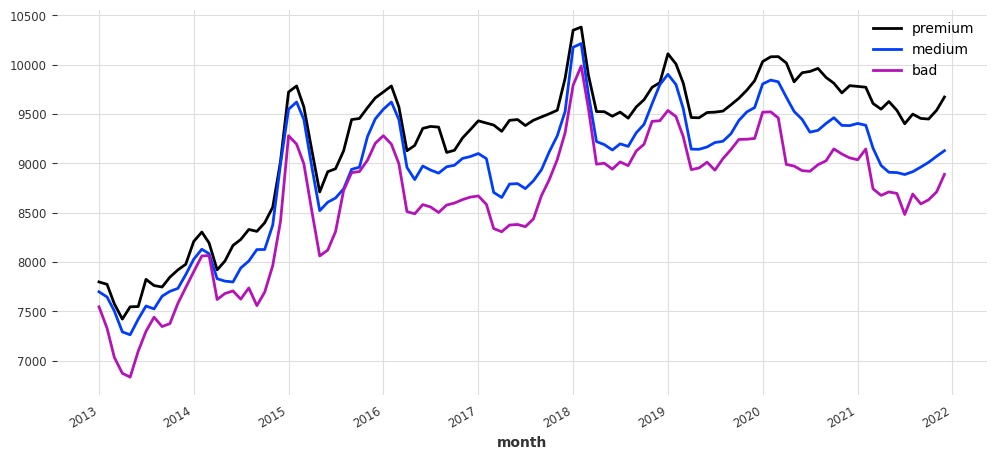

In [4]:
# plot the observation
plt.figure(1000, figsize=(12, 5))
series.plot()

In [5]:
# analyze its seasonality
def seasonality(category:str):
    is_seasonal, periodicity = check_seasonality(ts[category])
    dict_seas ={
        "rice category":category,
        "is seasonal?":is_seasonal, 
        "periodicity (months)":f'{periodicity:.1f}', 
        "periodicity (~years)": f'{periodicity/12:.1f}'}
    _ = [print(k,":",v) for k,v in dict_seas.items()]
    
    # plot its autocorelation function
    plot_acf(ts['premium'], periodicity, max_lag=len(ts)-1)

rice category : premium
is seasonal? : False
periodicity (months) : 0.0
periodicity (~years) : 0.0


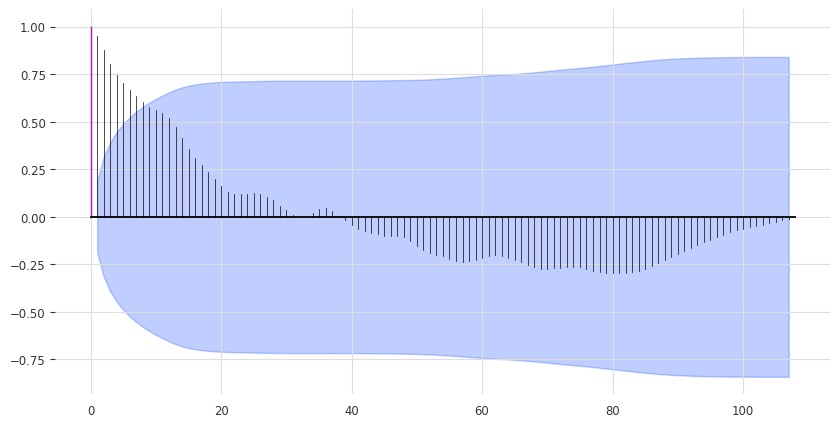

In [6]:
seasonality('premium')

rice category : medium
is seasonal? : True
periodicity (months) : 11.0
periodicity (~years) : 0.9


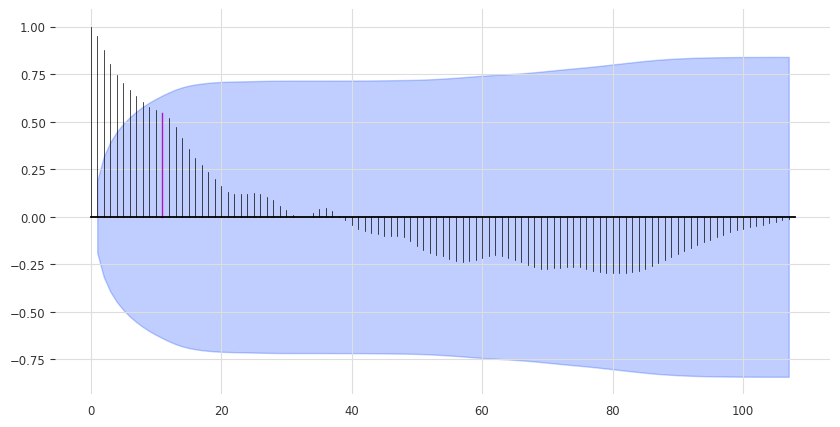

In [7]:
seasonality('medium')

rice category : bad
is seasonal? : True
periodicity (months) : 11.0
periodicity (~years) : 0.9


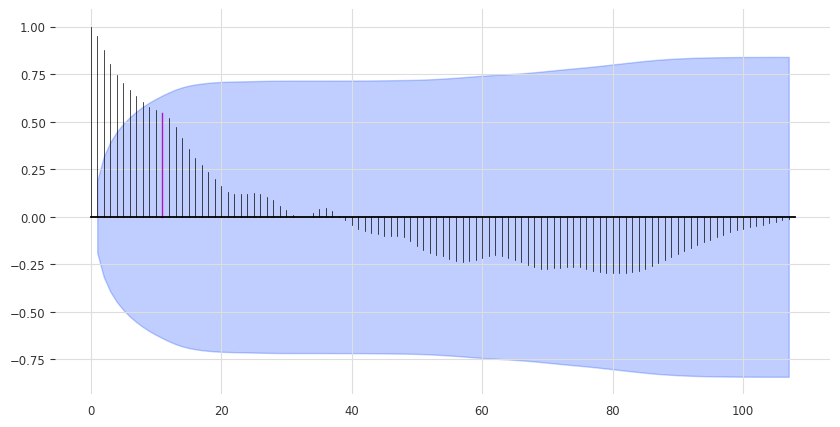

In [8]:
seasonality('bad')

In [9]:
# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))

In [10]:
# normalize the time series
trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)
ts_trf.head()

<TimeSeries (DataArray) (month: 5, component: 3, sample: 1)>
array([[[0.1272906 ],
        [0.14750885],
        [0.22590319]],

       [[0.11906032],
        [0.12979397],
        [0.15714757]],

       [[0.05253257],
        [0.08178909],
        [0.06353111]],

       [[0.        ],
        [0.00990367],
        [0.01210071]],

       [[0.04210711],
        [0.        ],
        [0.        ]]])
Coordinates:
  * month      (month) datetime64[ns] 2013-01-01 2013-02-01 ... 2013-05-01
  * component  (component) object 'premium' 'medium' 'bad'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [11]:
# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

In [34]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):
    torch_metrics = MeanAbsolutePercentageError()
    # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
    # a period of 5 epochs (`patience`)
    callback = EarlyStopping(
        monitor="val_MeanAbsolutePercentageError",
        patience=5,
        min_delta=0.05,
        mode='min',
    )

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=12,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True,
        save_checkpoints=True,
        torch_metrics=torch_metrics,
        pl_trainer_kwargs={"callbacks": [callback]}
        )
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # model_loaded = RNNModel.load_from_checkpoint(flavor + str(" RNN"), best=True)

    # compute N predictions
    pred = model_RNN.predict(FC_N) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

# helper function: fit the RNN model

def fit_it(model, train, val, flavor):

    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=False)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot()
    pred.plot(label=['premium_pred','medium_pred','bad_pred'])
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend()

# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    # compute accuracy metrics and processing time
    res_mape = mape(pred2, act2)
    res_mae = mae(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_rmsle = rmsle(pred2, act2)
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle}
    return res_accuracy


beginning the training of the LSTM RNN:
training of the LSTM RNN has completed: 1.78 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 10.5098
MAE : 0.0716
R squared : 17.9592
RMSE : 0.0873
RMSLE : 0.0508


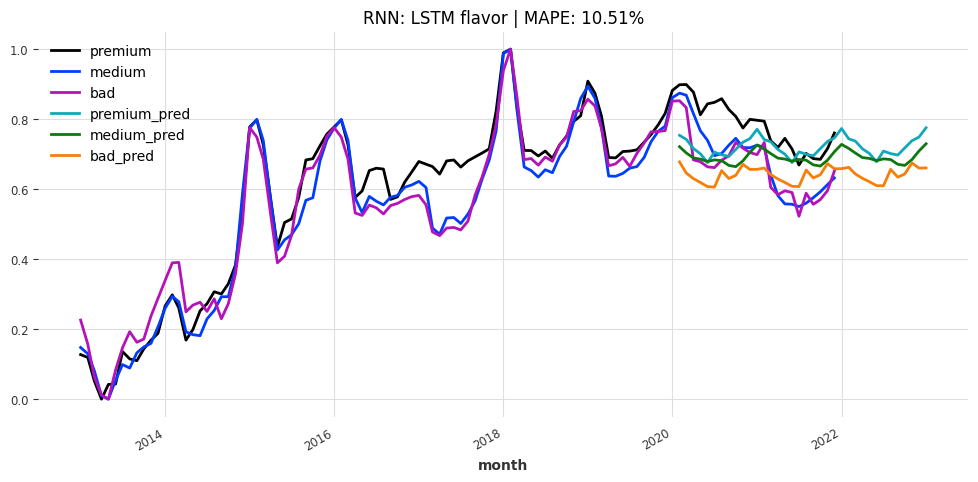

In [35]:
history = run_RNN('LSTM', ts_trf, train_trf, val_trf)
# list all data in history
# print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [24]:
history[1]

<TimeSeries (DataArray) (month: 36, component: 3, sample: 1)>
array([[[0.91508998],
        [0.88541438],
        [0.85398751]],

       [[0.81852266],
        [0.79680655],
        [0.77088561]],

       [[0.68384294],
        [0.66297274],
        [0.64208586]],

       [[0.65704505],
        [0.6145766 ],
        [0.61349899]],

       [[0.70411019],
        [0.63435492],
        [0.63297662]],

...

       [[0.840823  ],
        [0.77970826],
        [0.79026938]],

       [[0.86004752],
        [0.79553836],
        [0.81276541]],

       [[0.90052726],
        [0.84810048],
        [0.85815007]],

       [[0.95521519],
        [0.92051924],
        [0.90396569]],

       [[1.06547402],
        [1.01768026],
        [0.98707988]]])
Coordinates:
  * month      (month) datetime64[ns] 2020-02-01 2020-03-01 ... 2023-01-01
  * component  (component) object 'premium' 'medium' 'bad'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


beginning the training of the LSTM RNN:
training of the LSTM RNN has completed: 27.88 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 12.5638
MAE : 0.0919
R squared : 0.9786
RMSE : 0.1084
RMSLE : 0.0630

beginning the training of the GRU RNN:
training of the GRU RNN has completed: 27.45 sec


Predicting: 0it [00:00, ?it/s]

GRU : 
MAPE : 12.8105
MAE : 0.0958
R squared : 0.7800
RMSE : 0.1111
RMSLE : 0.0642

beginning the training of the Vanilla RNN:
training of the Vanilla RNN has completed: 20.67 sec


Predicting: 0it [00:00, ?it/s]

Vanilla : 
MAPE : 13.1609
MAE : 0.1018
R squared : 1.3580
RMSE : 0.1190
RMSLE : 0.0686


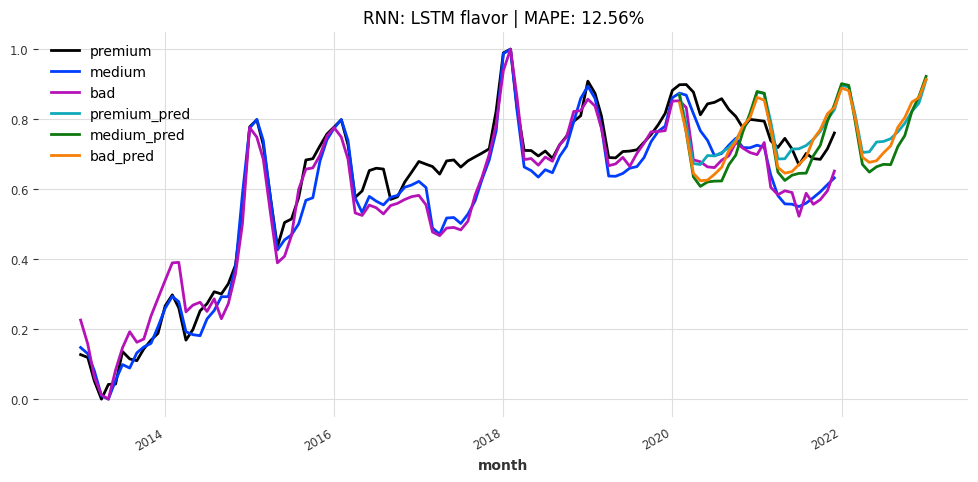

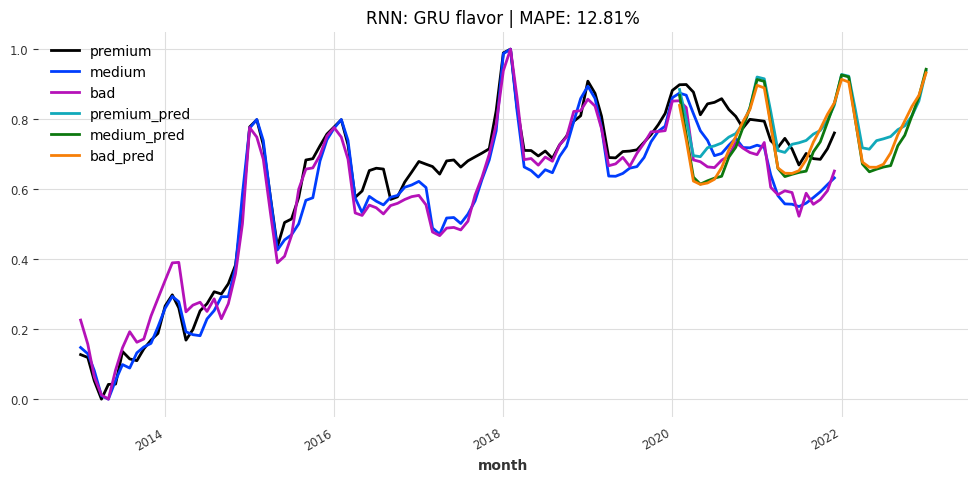

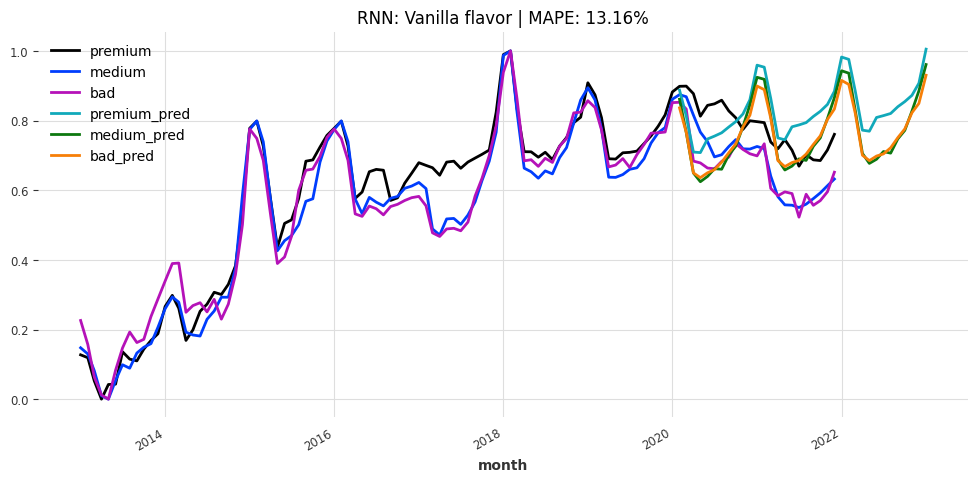

In [69]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]

In [64]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
    "Vanilla":res_flavors[2][1]}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,LSTM,GRU,Vanilla
MAPE,13.988968,13.390752,13.527597
MAE,0.109233,0.102667,0.106181
R squared,1.284469,1.111620,1.501161
RMSE,0.128734,0.119693,0.125298
RMSLE,0.074095,0.069034,0.072103
